<a href="https://colab.research.google.com/github/azimi99/Upperbound2024-Kaggle/blob/main/Upperbound_2024_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Puddle World**

In this guide, we provide a step-by-step walkthrough on preparing the Puddle World environment for the Competition.

Firstly, we cover the installation of the environment and related dependencies, both for local setup and utilization within a Colab notebook.

Next, we detail the process of initializing the environment with desired configurations and demonstrate how to visualize its characteristics. The goal of the competition is to design an agent that does well in the five provided configurations. Therefore, we show you how to load all the various versions of the environment and inspect their characteristics.

Given the objective of designing a competent agent, we present suggestions for deploying random, human, or untuned DQN agents within the environment. Observing all these different baseline behaviors serves as a valuable starting point for your work.

Finally, it's time to design and train a single agent capable of superior performance across the five configurations of the environment. Testing the agent on these configurations, with the first being the default environment as described in the paper, is crucial. We provide instructions on saving results in a CSV file for submission, marking the beginning of your journey.

Whether you're new to the field and eager to explore or an experienced practitioner aiming to refine your skills, this competition provides a platform to utilize your knowledge and creativity!

# 1. Installing the Requirements

In this section, you can find the necessary information for installing the environment and relavant libraries for your work.

## 1.1. For Google Colab

You can access the gym-puddle library for colab by installing the repository by the following command.
You can also include other necessary installations of your own here.

In [ ]:
!pip install git+https://github.com/Amii-Open-Source/gym-puddle.git
!pip install git+https://github.com/DLR-RM/stable-baselines3@f375cc393938a6b4e4dc0fb1de82b4afca37c1bd
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay
!pip install --upgrade ipykernel

  Cloning https://github.com/Amii-Open-Source/gym-puddle.git to /tmp/pip-req-build-elpnw79i
  Running command git clone --filter=blob:none --quiet https://github.com/Amii-Open-Source/gym-puddle.git /tmp/pip-req-build-elpnw79i
  Resolved https://github.com/Amii-Open-Source/gym-puddle.git to commit 7ddd0ec98bf476aa6ea116c3e7168986663166a1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 19.2 MB/s eta 0:00:00
  Created wheel for gym-puddle: filename=gym_puddle-0.0.2-py3-none-any.whl size=4852 sha256=d4817ee0d4f509e6a1d8a87a8dae78a10d2dfa57393e2466104ff83e10190587
  Stored in directory: /tmp/pip-ephem-wheel-cache-ru0li1sv/wheels/ff/ea/4e/a496612f0dee8c032274426e2395548711b7ee6c0added3c99
Successfully built gym-puddle
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-

# 2. Introduction to the Environment

The "Puddle World" environment provides an interface for reinforcement learning experiments. It features puddles and challenges agents to navigate to specified goal positions while avoiding the puddles with larger negative rewards.
You can access key details like starting position, goal location, and action noise levels. By printing these attributes, you can gain insights into the environment's layout and develop strategies for training reinforcement learning algorithms effectively within the Puddle World domain.
Here is the default Puddle World configuration inspired by the [original paper](/http://incompleteideas.net/papers/sutton-96.pdf):

**Actions**

There are four actions: up, down, right, and left.
Each action moves approximately 0.05 in these directions. For the case where an action would take the agent out of the screen limits, the action does not move the agent instead.

A random gaussian noise with standard deviation 0.01 is also added to the motion along both dimensions.

**Reward**

The reward is -1 for each time step, plus some additional penalty if the agent gets into the puddle.
The penalty is -400 times the distance into the puddle (distance to the nearest edge).


**Puddle Positions**

The puddles's top-left position is [0.  , 0.85] and [0.35, 0.9] respectively, and the width and height for them is [0.55, 0.2 ] and [0.2, 0.6].

**Start Position**

The agent starts each episode at [0.2, 0.4].

**Goal Position**

The episode ends succesfully if the agent reaches [1.0, 1.0] which is the goal position.


In [ ]:
import gymnasium as gym
import gym_puddle

from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy as DQNPolicy

import time
import json

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython import display
import pyvirtualdisplay
import cv2

Here are the printed details about the environment.

In [ ]:
  env = gym.make("PuddleWorld-v0")

  print("start position:", env.get_wrapper_attr("start"))
  print("goal position:", env.get_wrapper_attr("goal"))
  print("goal threshold:", env.get_wrapper_attr("goal_threshold"))
  print("action noise:", env.get_wrapper_attr("noise"))
  print("agent's thrust:", env.get_wrapper_attr("thrust"))
  print("puddle top left positions:", env.get_wrapper_attr("puddle_top_left"))
  print("puddle widths and heights:", env.get_wrapper_attr("puddle_width"))
  print("action space:", env.get_wrapper_attr("actions"))
  print("observation space:", env.get_wrapper_attr("observation_space"))
  print("observation space:", env.spec.id)

start position: [0.2 0.4]
goal position: [1. 1.]
goal threshold: 0.1
action noise: 0.01
agent's thrust: 0.05
puddle top left positions: [array([0.  , 0.85]), array([0.35, 0.9 ])]
puddle widths and heights: [array([0.55, 0.2 ]), array([0.2, 0.6])]
action space: [array([-0.05,  0.  ]), array([0.05, 0.  ]), array([ 0.  , -0.05]), array([0.  , 0.05])]
observation space: Box(0.0, 1.0, (2,), float64)
observation space: PuddleWorld-v0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


Here is the visualization of the environment for the default configuration.

In [ ]:
#some functions to help the visualization and interaction wit the environment

def visualize(frames, video_name = "video.mp4"):
    # Saves the frames as an mp4 video using cv2
    video_path = video_name
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(video_path, fourcc, 30, (width, height))
    for frame in frames:
        video_writer.write(frame)
    video_writer.release()

def online_rendering(image):
    #Visualize one frame of the image in a display
    ax.axis('off')
    img_with_frame = np.zeros((image.shape[0]+2, image.shape[1]+2, 3), dtype=np.uint8)
    img_with_frame[1:-1, 1:-1, :] = image
    ax.imshow(img_with_frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def prepare_display():
  #Prepares display for onine rendering of the frames in the game
  _display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
  _ = _display.start()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.axis('off')


def get_action():
    action = None
    while action not in ["w", "a", "s", "d", "W", "A", "S", "D"]:
        action = input("Enter action (w/a/s/d): ")
    if action == "w":
        return 3
    elif action == "a":
        return 0
    elif action == "s":
        return 2
    elif action == "d":
        return 1


#4. Now It's Your Turn!

Now, you're invited to dive into the world of reinforcement learning and take control of the Puddle World environment. We encourage you to become an active participant by modifying the provided code, tweaking parameters, and experimenting with different strategies. You can come up with your own agent ideas, or use pre-exisiting libraries, and adapt them to the problem.


The goal is to build **a single agent that can generalize well across all the environment configurations.**
Once you have built your agent, test your trained agent with 100 different seeds, each seed for one episode, in the five provided configurations, save the total reward in each episode for each configuration, and submit the results as a `.csv` file as indicated in the Kaggle platform. You can set different seeds for the environment with `env.reset(seed = n)`) with `n` being the number from 1 to 100.

 Whether you're a beginner eager to explore or an experienced practitioner seeking to refine your skills, this competition offers an opportunity to apply your knowledge and creativity.



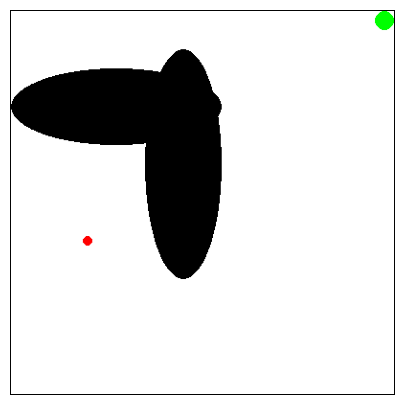

In [ ]:
## Visualize Environment
json_file = f"/content/pw1.json"

with open(json_file) as f:
  env_setup = json.load(f)

env1 = gym.make(
  "PuddleWorld-v0",
  start=env_setup["start"],
  goal=env_setup["goal"],
  goal_threshold=env_setup["goal_threshold"],
  noise=env_setup["noise"],
  thrust=env_setup["thrust"],
  puddle_top_left=env_setup["puddle_top_left"],
  puddle_width=env_setup["puddle_width"],
)
puddle_top_left=env_setup["puddle_top_left"]
puddle_width=env_setup["puddle_width"]
obs, info = env1.reset()
image = env1.render()
fig, ax = plt.subplots(figsize=(5, 5))
online_rendering(image)

In [ ]:
seed = 0
np.random.seed(seed)

## TILE-CODING CONFIGURATION
n_tiles_per_dim = 10
tile_width = 1/n_tiles_per_dim
num_tilings = 20
offset_vals = np.random.uniform(low=-tile_width, high=tile_width, size=(num_tilings, 2))

def state_update_func(obs): # Constructs markov state

  tmp_obs = obs
  state_vec = np.zeros(shape=(n_tiles_per_dim, n_tiles_per_dim))
  for i in range(num_tilings):
    offset = offset_vals[i]
    obs = tmp_obs + offset
    state_vec_tmp = np.zeros(shape=(n_tiles_per_dim, n_tiles_per_dim))
    if not (obs[0] < 0 or obs[0] > 1 or obs[1]<0 or obs[1] >1): # not out of bounds
      state_vec_tmp[int(obs[0]/tile_width) - 1][int(obs[1]/tile_width) - 1] = 1
    if i == 0:
      state_vec = state_vec_tmp
      continue
    state_vec = np.append(state_vec, state_vec_tmp)

  return state_vec.flatten()

def q(state, action, weights): # State-Action value
  return weights.dot(x_sa(state, action))

def x_sa(state, action): # State-Action feature vector
  x_sa = np.zeros(shape=(4, state.shape[-1]))
  x_sa[action] = state
  return x_sa.flatten()

def sample_action(env, epsilon, state, weights): # Policy, PI
  binomial_trial = np.random.rand()
  if binomial_trial < epsilon:
    return env.action_space.sample()
  else:
    return np.argmax([q(state, action, weights) for action in [0, 1, 2, 3]])

def create_env_state(puddle_top_left, puddle_width): # Tile code the environment config

  puddle_vec = np.zeros(shape=(n_tiles_per_dim, n_tiles_per_dim))
  for i in range(num_tilings):
    puddle_vec_tmp = np.zeros(shape=(n_tiles_per_dim, n_tiles_per_dim))
    for p in puddle_top_left:
      p_off = p + offset_vals[i]
      if not (p_off[0] < 0 or p_off[0] > 1 or p_off[1]<0 or p_off[1] >1):
        puddle_vec_tmp[int(p[0]/tile_width) - 1][int(p[1]/tile_width) - 1] = 1
      if i == 0:
        puddle_vec = puddle_vec_tmp
        continue
      puddle_vec = np.append(puddle_vec, puddle_vec_tmp)

    puddle_vec_width = np.zeros(shape=(n_tiles_per_dim, n_tiles_per_dim))
    for p in puddle_width:
      puddle_vec_width_tmp = np.zeros(shape=(n_tiles_per_dim, n_tiles_per_dim))
      p_off = p + offset_vals[i]
      if not (p_off[0] < 0 or p_off[0] > 1 or p_off[1]<0 or p_off[1] >1):
        puddle_vec_width_tmp[int(p[0]/tile_width) - 1][int(p[1]/tile_width) - 1] = 1
      if i == 0:
        puddle_vec_width = puddle_vec_width_tmp
        continue
      puddle_vec_width = np.append(puddle_vec, puddle_vec_width_tmp)

  return np.append(puddle_vec, puddle_vec_width).flatten()



In [ ]:
### SEMIGRADIENT n-STEP SARSA
def learn(env,
          weights={},
          seed=0,
          episodes = 3000,
          gamma = 0.999,
          epsilon=0.1,
          num_tilings=100,
          n_steps=4,
          anneal_lr = 0.999999,
          anneal_exploration=0.9999):
  # print(f"BEGIN TRAINING ON: {env.spec.id}")
  done = False
  stepsize = 1/(num_tilings * 5)
  episode_rewards = []
  total_reward = 0
  env_state = create_env_state(env.get_wrapper_attr("puddle_top_left"), env.get_wrapper_attr("puddle_top_left"))
  np.random.seed(seed)
  pbar = tqdm(range(episodes))
  for _ in pbar:
    obs, info = env.reset(seed=seed)
    state = state_update_func(obs)
    weight_vec = weights.get(env_state.tobytes(), np.zeros(state.shape[0] * 4))
    action = sample_action(env, epsilon, state, weight_vec)  # take action epislon greedy
    done = False
    step = 0
    reward_buffer = []
    while not done:
      q_val = q(state, action, weight_vec)
      obs, reward, done, trunc, info = env.step(action)
      reward_buffer.append(reward)
      step += 1
      next_state = state_update_func(obs)
      next_action = sample_action(env, epsilon, state, weight_vec)

      if done:
        G = sum([reward_buffer[i]*gamma**i for i in range(len(reward_buffer))])
        weight_vec  = weight_vec\
        + stepsize * (G - q_val)*x_sa(state, action)
        stepsize *= anneal_lr
      elif step % n_steps == 0:
        G = sum([reward_buffer[i]*gamma**i for i in range(n_steps)])
        next_q_val= q(next_state, next_action, weight_vec)
        weight_vec  = weight_vec \
        + stepsize * (G + (gamma**n_steps) * next_q_val - q_val)*x_sa(state, action)
        stepsize *= anneal_lr
        reward_buffer = []


      state = next_state
      action = next_action

      total_reward += reward
    weights[env_state.tobytes()] = weight_vec

    if done:
      # print(f"total reward in this episode {_}: {total_reward}")
      # episode_rewards.append(total_reward)
      pbar.set_postfix({'total_reward': total_reward})
      epsilon *= anneal_exploration
      total_reward = 0
  # print("Training complete")
  env.close()
  return weights


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [ ]:
#### Create Environments ####
env_list = []
for i in range(1,6):
  json_file = f"/content/pw{i}.json"

  with open(json_file) as f:
    env_setup = json.load(f)

  env_list.append(gym.make(
    "PuddleWorld-v0",
    start=env_setup["start"],
    goal=env_setup["goal"],
    goal_threshold=env_setup["goal_threshold"],
    noise=env_setup["noise"],
    thrust=env_setup["thrust"],
    puddle_top_left=env_setup["puddle_top_left"],
    puddle_width=env_setup["puddle_width"],
  ))

In [ ]:
weights = {}

In [ ]:
## CONDUCTING EXPERIMENTS
seed = 100

for env in env_list:
  for epoch in range(5):
    weights = learn(env,
                    episodes=5000,
                    weights=weights,
                    seed=seed,
                    num_tilings=num_tilings,
                    anneal_lr=1.0,
                    n_steps=1)

100%|██████████| 5000/5000 [01:49<00:00, 45.84it/s, total_reward=-42]


In [ ]:
np.save("weights-2.npy", weights)

In [ ]:
#### SUBMISSION ####
weights = np.load("weights-2.npy", allow_pickle=True).item()

In [ ]:
import pandas as pd

# Assuming you have a list of 100 episodic rewards for each configuration
# Example data structure: [(config1_rewards), (config2_rewards), ...]

# Replace this example data with your actual rewards data
episode_rewards_per_configuration = [
]

for indx, env in enumerate(env_list):
  episodic_rewards=[]

  done = False
  env_state = create_env_state(env.get_wrapper_attr("puddle_top_left"), env.get_wrapper_attr("puddle_top_left"))
  for seed in range(1, 101):
    obs,_ = env.reset(seed=seed)
    total_reward = 0
    state = state_update_func(obs)
    while not done:
      action = sample_action(env, 0.0, state, weights[env_state.tobytes()])  # take action epislon greedy
      obs, reward, done, trunc, info = env.step(action)
      total_reward += reward
      state = state_update_func(obs)
      image = env.render()
    episodic_rewards.append(total_reward)
    done = False
  episode_rewards_per_configuration.append(episodic_rewards)


# Define the column names
columns = ['seed_ID', 'ep_reward_pw1', 'ep_reward_pw2', 'ep_reward_pw3', 'ep_reward_pw4', 'ep_reward_pw5']

# Create a list of dictionaries to store data
data = []

# Populate the list with episode IDs and rewards
for episode_id in range(1, 101):  # Assuming 100 episodes
    row_data = {'seed_ID': episode_id}
    for i, rewards in enumerate(episode_rewards_per_configuration):
        row_data[columns[i + 1]] = rewards[episode_id - 1]
    data.append(row_data)

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Define the file name for saving the results
csv_file_name = "submission.csv"

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)

print("Results saved successfully to", csv_file_name)

Results saved successfully to submission.csv


In [ ]:

import pandas as pd

# Define the file name for loading the results
csv_file_name = "submission.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_name)

# Display the DataFrame
print(df)
print(df.mean())

    seed_ID  ep_reward_pw1  ep_reward_pw2  ep_reward_pw3  ep_reward_pw4  \
0         1            -39            -35            -34            -36   
1         2            -37            -34            -28            -36   
2         3            -41            -35            -28            -38   
3         4            -38            -34            -35            -35   
4         5            -43            -36            -34            -40   
..      ...            ...            ...            ...            ...   
95       96            -40            -44            -28            -39   
96       97            -38            -34            -42            -47   
97       98            -44            -40            -28            -31   
98       99            -42            -34            -31            -34   
99      100            -38            -32            -28            -33   

    ep_reward_pw5  
0             -37  
1             -39  
2             -38  
3             -38  

In [ ]:
df.loc[:, 'ep_reward_pw1':].values.mean()

-37.066

In [ ]:
### VISUALIZE ENVIRONMENTS: GENERATE VIDEOS ###

for indx, env in enumerate(env_list):
  frames=[]
  done = False
  env_state = create_env_state(env.get_wrapper_attr("puddle_top_left"), env.get_wrapper_attr("puddle_top_left"))
  for _ in range(10):
    obs,_ = env.reset()
    state = state_update_func(obs)
    while not done:
      action = sample_action(env, 0.0, state, weights[env_state.tobytes()])  # take action epislon greedy
      obs, reward, done, trunc, info = env.step(action)
      state = state_update_func(obs)
      image = env.render()
      frames.append(image)
    done = False

  visualize(frames, f"config-{indx}.mp4")
